In [50]:
%matplotlib inline 
import sys
sys.path.append("..")


import numpy as np
import random
import csv

from idtrees.utils import read_tifs #, load_data # Import data utils
from idtrees.utils.get_data import *
import matplotlib.pyplot as plt
from configs import *

import pandas as pd
from sklearn.model_selection import train_test_split


### Extracting ITCs as differently sized HSI images with a Tree Species Label

In [51]:
im_all_new, new_class_ids, class_id_val, n_px_val, sci_names, special_val_px = get_data()

Number of trees, labeled with species and bounding box:  1165
[WARNING] Loaded box has zero shape and is sketchily inflated. TODO: skip this box with ID 749
[WARNING] Loaded box has zero shape and is sketchily inflated. TODO: skip this box with ID 1046
Classes to be used: [23. 26. 22.  2. 30. 18.]
Counts for these classes [ 53.  97. 103. 139. 169. 367.]
Number of trees, labeled with species and bounding box:  1165
[WARNING] Loaded box has zero shape and is sketchily inflated. TODO: skip this box with ID 749
[WARNING] Loaded box has zero shape and is sketchily inflated. TODO: skip this box with ID 1046


In [52]:
spectra = [] # List of spectrum per pixel # TODO write as ndarray
class_id_new = [] # List of target per pixel 

for index in range(len(im_all_new)):
    # Append the spectra and class id of all pixels in bbox to a list
    n_px = np.prod(im_all_new[index].shape[1:])
    spectra.append(im_all_new[index].reshape(-1, n_px))
    class_id_new.append(new_class_ids[index] * np.ones(n_px))

# Convert list into ndarray
spectra = np.concatenate(spectra, axis=1)#.numpy())
class_id_new = np.concatenate(class_id_new, axis=0)

# Add class ids as zero'th row 
pixel_data = np.vstack((class_id_new[np.newaxis,:], spectra))


In [53]:
freq = pd.DataFrame({'class_ids': class_id_val, 'num_pix': n_px_val, 'sci_names': sci_names})
freq.loc[6, :] = ['34.', str(np.sum(special_val_px)), "ALL OTHER"]

In [54]:
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets

In [55]:
# Prepare data
n_train = int(.8 * pixel_data.shape[1])
xy = np.rollaxis(pixel_data, 1) # Format X into (n_samples, n_features)
np.random.shuffle(xy) # Shuffle randomly along axis of n_samples 
X = xy[:, 1:] 
Y = xy[:, 0]

In [56]:
# Do PCA
do_pca = True
if do_pca:
    pca = PCA(n_components='mle', whiten=False, svd_solver='full')
    X = pca.fit_transform(X)
print('Shape after [PCA]', X.shape)

Shape after [PCA] (35488, 360)


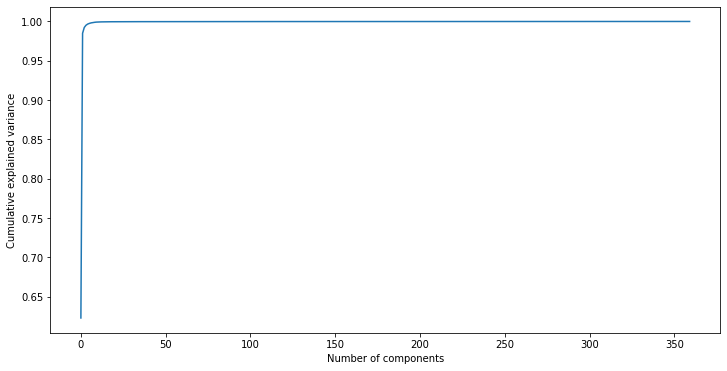

In [57]:
ev=pca.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')


plt.show()

In [58]:
pca = PCA(n_components=40)
X = pca.fit_transform(X)

In [59]:
X_train = X[:n_train, :]
y_train = Y[:n_train]
X_test = X[n_train:, :]
y_test = Y[n_train:]

## 1. Initial SVM

In [9]:
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train)
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train, y_train)

In [10]:
linear_pred = linear.predict(X_test)
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)
sig_pred = sig.predict(X_test)

# retrieve the accuracy and print it for all 4 kernel functions
accuracy_lin = linear.score(X_test, y_test)
accuracy_poly = poly.score(X_test, y_test)
accuracy_rbf = rbf.score(X_test, y_test)
accuracy_sig = sig.score(X_test, y_test)

print("Accuracy Linear Kernel:", accuracy_lin)
print("Accuracy Polynomial Kernel:", accuracy_poly)
print('Accuracy Radial Basis Kernel:', accuracy_rbf)
print('Accuracy Sigmoid Kernel:', accuracy_sig)
      
# creating a confusion matrix
cm_lin = confusion_matrix(y_test, linear_pred)
cm_poly = confusion_matrix(y_test, poly_pred)
cm_rbf = confusion_matrix(y_test, rbf_pred)
cm_sig = confusion_matrix(y_test, sig_pred)
      
print(cm_lin)
print(cm_poly)
print(cm_rbf)
print(cm_sig)

Accuracy Linear Kernel: 0.6108763031839954
Accuracy Polynomial Kernel: 0.503803888419273
Accuracy Radial Basis Kernel: 0.6107354184277262
Accuracy Sigmoid Kernel: 0.2948717948717949
[[ 362    2   10    0    0  306  231]
 [   0 1732    0    0   45    0   21]
 [  79    0  278    0    0  319  175]
 [  42    0    3    0    0  270   96]
 [   0  167    0    0  211    0    3]
 [  51    0   29    0    0  970  186]
 [ 160   46   92    0    8  421  783]]
[[  77    0    4    0    0  608  222]
 [   1 1525    0    0   25  218   29]
 [  17    0   71    0    0  472  291]
 [   4    2    1    0    0  333   71]
 [   0  199    0    0  138   40    4]
 [  15    8    2    0    0 1033  178]
 [  28   52   18    0    1  679  732]]
[[ 339    2   18    0    0  279  273]
 [   1 1751    0    0   30    0   16]
 [  81    0  260    0    0  278  232]
 [  66    2   23    6    0  217   97]
 [   0  215    0    0  163    0    3]
 [  80    3   49    1    0  918  185]
 [ 162   45   80    0    1  324  898]]
[[ 186   30  305 

## 2. Rebalanced, removing Other, normalize

In [60]:
## Lets normalize and center the data
X_std = X - X.mean(axis=1).reshape(-1,1)
X_std = X_std/X_std.std(axis=1).reshape(-1,1)

## Lets leave out 34
X_std = X_std[Y != 34, :]
Y_std = Y[Y!=34]

X_train, X_test, y_train, y_test = train_test_split(X_std, Y_std, test_size=0.2, random_state=2)


In [61]:
X_train.shape, y_train.shape

((22468, 40), (22468,))

In [62]:
def rebalance_data(X_ub, Y_ub, up_balance_scale=3.):
    # Get classes and counts
    vals, counts = np.unique(Y_ub, return_counts=True)
    # See how bad the inbalance is and choose n_choose according to up_balance_scale
    if counts.max()/counts.min() >up_balance_scale:
        n_choose = int(counts.min()*up_balance_scale)
    else:
        n_choose = int(counts.max())

    X_new = np.zeros((n_choose*vals.shape[0], X_ub.shape[1]))
    Y_new = np.zeros(n_choose*vals.shape[0])
    for i, val in enumerate(vals):
        bool_arr = (Y_ub == val)
        if n_choose-bool_arr.sum()<0:
            random_idxs = np.random.randint(counts[i], size=(n_choose))
            X_new[i*n_choose:(i+1)*n_choose,:] = X_ub[bool_arr, :][random_idxs,:]
        else:
            random_idxs = np.random.randint(counts[i], size=(n_choose-bool_arr.sum()))
            X_new[i*n_choose:(i+1)*n_choose,:] = np.concatenate((X_ub[bool_arr, :],X_ub[bool_arr, :][random_idxs,:]),
                                                                axis=0)
        Y_new[i*n_choose:(i+1)*n_choose] = val
    return X_new, Y_new
X_train, y_train = rebalance_data(X_train, y_train)


## 3. Re-run SVM

In [63]:
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train)

linear_pred = linear.predict(X_test)
rbf_pred = rbf.predict(X_test)

# retrieve the accuracy and print it for all 4 kernel functions
accuracy_lin = linear.score(X_test, y_test)
accuracy_rbf = rbf.score(X_test, y_test)

print("Accuracy Linear Kernel:", accuracy_lin)
print('Accuracy Radial Basis Kernel:', accuracy_rbf)
      
# creating a confusion matrix
cm_lin = confusion_matrix(y_test, linear_pred)
cm_rbf = confusion_matrix(y_test, rbf_pred)
      
print(cm_lin)
print(cm_rbf)

Accuracy Linear Kernel: 0.6882677585899947
Accuracy Radial Basis Kernel: 0.7048246394872708
[[ 498    1   72  188    0  206]
 [   0 1506    0    0  212    0]
 [ 110    0  494  147    0  128]
 [  45    0   13  294    0   48]
 [   0   57    0    0  333    0]
 [ 142    0   94  288    0  741]]
[[ 559   15   89  112    0  190]
 [   1 1475    0    0  242    0]
 [ 167    6  519   60    0  127]
 [  78    2   31  243    0   46]
 [   0   63    0    0  326    1]
 [ 172    4  125  127    0  837]]


## 3. Running new models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

'''
Lightweight script to test many models and find winners
:param X_train: training split
:param y_train: training target vector
:param X_test: test split
:param y_test: test target vector
:return: DataFrame of predictions
'''

dfs = []
models = [('LogReg', LogisticRegression(max_iter=1e4)), 
          ('RF', RandomForestClassifier(n_jobs=4)),
          ('XGB', XGBClassifier()),
          ('KNN', KNeighborsClassifier(n_jobs=4)),
          ('SVM', SVC(kernel='linear', C=1, decision_function_shape='ovo'))
        ]
results = []
names = []
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
target_names = sci_names
for name, model in models:
    print(name, model, "="*10)
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
    cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names))
    print(confusion_matrix(y_test, y_pred))
    results.append(cv_results)
    names.append(name)
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
final = pd.concat(dfs, ignore_index=True)

LogReg LogisticRegression(max_iter=10000.0) ==========
LogReg
                       precision    recall  f1-score   support

       Acer rubrum L.       0.60      0.52      0.56       965
Pinus palustris Mill.       0.96      0.87      0.91      1718
      Quercus alba L.       0.67      0.59      0.63       879
     Quercus coccinea       0.34      0.63      0.44       400
Quercus laevis Walter       0.60      0.87      0.71       390
     Quercus rubra L.       0.65      0.59      0.62      1265

             accuracy                           0.69      5617
            macro avg       0.64      0.68      0.64      5617
         weighted avg       0.71      0.69      0.69      5617

[[ 504    5   96  150    0  210]
 [   0 1492    0    0  226    0]
 [ 116    0  521  116    0  126]
 [  57    0   26  251    0   66]
 [   0   52    0    0  338    0]
 [ 162    0  133  223    1  746]]
RF RandomForestClassifier(n_jobs=4) ==========
RF
                       precision    recall  f1-score   s

In [ ]:
name = 'SVM'
model = SVC(kernel='linear', C=1, decision_function_shape='ovo')

print(name, model, "="*10)
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
clf = model.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(name)
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred))
results.append(cv_results)
names.append(name)
this_df = pd.DataFrame(cv_results)
this_df['model'] = name
dfs.append(this_df)


SVM SVC(C=1, decision_function_shape='ovo', kernel='linear') ==========


In [ ]:
final = pd.concat(dfs, ignore_index=True)
final

In [ ]:
final.to_csv("../output/model_runs_BO.csv")